In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime

# 0 Loading Data 

In [2]:
t = time.time()
path  = r'/rfs/CAPAI_PhD_dflr2/Shared/Data/output/20220221_'
#file1 = path + 'admissions.txt' 
#file2 = path + 'eobs.txt'
file3 = path + 'haem-results.txt'
#file4 = path + 'icu.txt'
file5 = path + 'meds.txt'
file6 = path + 'micro-results.txt'
file7 = path + 'oxygen.txt'
file8 = path + 'prev_admissions.txt'
file9 = path + 'spin.txt'
#df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')
#df_eobs  = pd.read_csv(file2, sep='\t', lineterminator='\n')
df_haemt = pd.read_csv(file3, sep='\t', lineterminator='\n')
#df_icu   = pd.read_csv(file4, sep='\t', lineterminator='\n')
df_meds  = pd.read_csv(file5, sep='\t', lineterminator='\n')
df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
#df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')
#df_prev  = pd.read_csv(file8, sep='\t', lineterminator='\n')
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')

/local/dlr10/ipykernel_31851/1868901219.py:17: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')


In [3]:
##############################################################################
#######################################
### Relevant fields for pre-processing
#######################################
reference_date = datetime.datetime(1970,1,1)

##### Fields in table patients ##########
patient_field         = 'patient_id'
age_field             = 'age_at_admission\r'
sex_field             = 'sex'
ethnic_field          = 'ethnic_origin'
death_ind_field       = 'death_indicator'
death_date_field      = 'date_of_death'
death_date_code_field = 'date_code_of_death'
mort_in_hosp_field    = 'Thirty_day_mort'
patients_cols = [patient_field,sex_field, ethnic_field, death_ind_field, death_date_field, death_date_code_field, 
                 mort_in_hosp_field]

##### Fields in table admissions ########
admission_field           = 'admission_id'
diagnosis_field           = 'episode_diagnoses'
admn_date_field           = 'admission_date_time'
admn_discharge_field      = 'discharge_date_time'
admn_date_code_field      = 'admission_date_code_time'
admn_discharge_code_field = 'discharge_date_code_time'
lengthofstay_field        = 'lengthofstay'
isPneumonia_field         = 'isPneumonia'
mortal_admin_field        = 'mortal_admin'
comorbidity_field         = 'Comorbidity_score'
icu_admin_field           = 'icu_count\r'
no_eobs_field             = 'no_obs_eobs'
no_haematology_field      = 'no_haematology_eobs'

 ##### Fields in table eObservations #####
eObs_time_field      = 'timestamp'
eObs_time_code_field = 'timestamp_code'
eObs_time_prev_obs   = 'time_since_prev_obs_in_mins'
eObs_resprate_field  = 'rr'
eObs_sbp_field       = 'sbp'
eObs_dbp_field       = 'dbp'
eObs_newscore_field  = 'ews'
eObs_heartrate_field = 'heart_rate'
eObs_temptr_field    = 'temperature\r'
eObs_oxygen_field    = 'Oxygen_Saturation'

##### Fields in table haematological tests #####
test_code_field      = 'local_test_code'
test_time_field      = 'sample_collection_date_time'
test_time_code_field = 'sample_collection_date_code_time'
haemt_cols = [test_code_field, test_time_field, test_time_code_field]

In [4]:
#########################################################
# FORMATTING FIELD IN HAEMATOLOGY
#########################################################
t = time.time()
df_haemt = df_haemt.rename(columns = {'system_number':  'patient_id' })
df_haemt[test_time_field]      = pd.to_datetime(df_haemt[test_time_field], format='%Y-%m-%d %H:%M:%S')
df_haemt[test_time_code_field] = df_haemt[test_time_field] - reference_date
df_haemt[test_time_code_field] = df_haemt[test_time_code_field].apply(lambda x: x.days + (x.seconds/(24*3600)))
print("time elapsed: ", time.time() - t)

time elapsed:  158.53953528404236


In [5]:
#########################################################
# LOAD PREPROCESSED DF_PATIENTS, DF_ADMISSIONS 
#########################################################
data = pickle.load( open(r'DataFrame_pickles/df_patients_admissions_2019_2020_v2.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

# 1. EXPLORING RAW HAEMATOLOGY DATA

In [6]:
len(df_haemt['local_test_code'].unique().tolist())

1214

## df_haemt.head(5)

In [7]:
display(df_haemt[df_haemt['local_test_code']=='BILI'].head(4))

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time
22,26168041,2018-06-14 00:00:00,BILI,17,17,0{21,umol/L,Serum\r,17696.000000
24,48801982,2018-04-13 00:00:00,BILI,12,12,0{21,umol/L,Blood\r,17634.000000
59,33717929,2018-04-13 15:30:00,BILI,6,6,0{21,umol/L,Serum\r,17634.645833
68,13740482,2018-06-23 10:17:00,BILI,4,4,0{21,umol/L,Serum\r,17705.428472


### 1.1.Remove HAEMATOLOGY null's tests and duplicates

In [8]:
t = time.time()

print("Tests in heamatology", len(df_haemt))
df_haematology = df_haemt[df_haemt[patient_field].isin(df_patients[patient_field].unique().tolist())]
print("Test in heamatology of patients that have eObs too: ", len(df_haematology))
print("")
print('Number of Haem records with Local test nan:', len(df_haematology[df_haematology['local_test_code'].isnull()]))
df_haematology = df_haematology.drop(df_haematology[df_haematology['local_test_code'].isnull()].index, axis = 0)
print("Number of Haem records adter dropping nan's values test:", len(df_haematology))
# Remove duplicates
df_haematology = df_haematology.drop_duplicates(keep = 'first')
print("")
print("Heamatology samples after removing duplicates: ", len(df_haematology))
print("")
print("elapsed",time.time()-t)

Tests in heamatology 16620742
Test in heamatology of patients that have eObs too:  10722367

Number of Haem records with Local test nan: 380545
Number of Haem records adter dropping nan's values test: 10341822

Heamatology samples after removing duplicates:  10337081

elapsed 23.301887273788452


### 1.2. Rearrange df_haematology: Assign admission and filtering information from admissions needed

In [9]:
t = time.time()
df_haematology_new = pd.DataFrame(columns = df_haemt.columns)
df_haematology_new[admission_field ] = 0

patients_in_haemt = df_haematology[patient_field].unique().tolist()
t = time.time()
for pat in patients_in_haemt:
    pat_admissions = df_admissions[df_admissions[patient_field] == pat][admission_field].tolist()
    
    for pat_admin in pat_admissions:
        min_admin_date = df_admissions[(df_admissions[patient_field] == pat) & (df_admissions[admission_field]== pat_admin)][admn_date_code_field].min()
        max_admin_date = df_admissions[(df_admissions[patient_field] == pat) & (df_admissions[admission_field]== pat_admin)][admn_discharge_code_field].max()
        temp = df_haematology[(df_haematology[patient_field] == pat) 
                              & (df_haematology[test_time_code_field] >= int(min_admin_date) - 1) 
                              & (df_haematology[test_time_code_field] <= int(max_admin_date) + 1)].sort_values(by=test_time_field)
        temp[admission_field] = pat_admin
        df_haematology_new = pd.concat([df_haematology_new,temp]) if len(temp) > 0 else df_haematology_new
    
print("elapsed",time.time()-t)

elapsed 4693.511431217194


In [10]:
print("number of records before filtering", len(df_haematology))
print("number of records after filtering", len(df_haematology_new))

number of records before filtering 10337081
number of records after filtering 2994925


In [11]:
df_haematology_new.head()

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time,admission_id
9282272,41301822,2020-09-14 13:53:00,TROI,37.4,37.4,NaN,ng/L,Serum\r,18519.578472,9297156
8536309,41301822,2020-09-14 13:58:00,ALB,43,43,35{50,g/L,Plasma\r,18519.581944,9297156
9309627,41301822,2020-09-14 13:58:00,NEUAB,15.53,15.53,1.50{7.50,x10^9/L,Plasma\r,18519.581944,9297156
9309638,41301822,2020-09-14 13:58:00,APTT,25.3,25.3,24.0{33.0,secs,Plasma\r,18519.581944,9297156
9311813,41301822,2020-09-14 13:58:00,HDL,1.1,1.1,0.9{2.2,mmol/L,Plasma\r,18519.581944,9297156


# 2. Pickle df_haematology_V0

In [12]:
pickling_data = [df_haematology_new]
pickle.dump(pickling_data, open('DataFrame_pickles/df_haematology_v0_1.pickle', 'wb'))

# 3. Load Pickle df_haematology_v0

In [13]:
df_pikcled_data = pickle.load( open('DataFrame_pickles/df_haematology_v0_1.pickle', 'rb')) 
df_haematology_new = df_pikcled_data[0]
display(df_haematology_new.head(5) )

,patient_id,sample_collection_date_time,local_test_code,result,result_expansion,refererence_range,units,specimen_type\r,sample_collection_date_code_time,admission_id
9282272,41301822,2020-09-14 13:53:00,TROI,37.4,37.4,NaN,ng/L,Serum\r,18519.578472,9297156
8536309,41301822,2020-09-14 13:58:00,ALB,43,43,35{50,g/L,Plasma\r,18519.581944,9297156
9309627,41301822,2020-09-14 13:58:00,NEUAB,15.53,15.53,1.50{7.50,x10^9/L,Plasma\r,18519.581944,9297156
9309638,41301822,2020-09-14 13:58:00,APTT,25.3,25.3,24.0{33.0,secs,Plasma\r,18519.581944,9297156
9311813,41301822,2020-09-14 13:58:00,HDL,1.1,1.1,0.9{2.2,mmol/L,Plasma\r,18519.581944,9297156


In [14]:
t = time.time()
#####################################################################
#Extraction of blood codes frequencies per patient and admissions
#####################################################################
df_blood_codes = df_haematology_new[test_code_field].value_counts()
aa = []
for i,x in enumerate(np.array(df_blood_codes)): 
    if np.array(df_blood_codes)[:i].sum() < 0.95 * len(df_haematology_new): aa.append(x)
df_blood_codes = df_blood_codes[:len(aa)]
df_blood_codes = df_blood_codes.to_frame()

df_blood_codes['no_patients']   = [len(df_haematology_new[df_haematology_new[test_code_field] == code][patient_field].unique().tolist()) for code in df_blood_codes.index]
df_blood_codes['no_admissions'] = [len(df_haematology_new[df_haematology_new[test_code_field] == code][admission_field].unique().tolist()) for code in df_blood_codes.index]

A = df_blood_codes.index.tolist()

print("Number of tests to consider")
print(len(df_blood_codes))
display(df_blood_codes.head(50))
print("elapsed",time.time()-t)

Number of tests to consider
38


,local_test_code,no_patients,no_admissions
UREA,103819,12778,14672
CREA,103819,12778,14672
K,103663,12778,14671
EGFR,103386,12769,14662
GFR,103155,12768,14660
WBC,101134,12775,14671
AKIDUM,100545,12773,14662
PLT,97209,12766,14660
HGB,97203,12766,14660
HCT,97203,12765,14658


elapsed 22.059683084487915


In [15]:
len(df_blood_codes)

38

# 4. Process Haematology respect to eObs


### Load eobs table 

In [16]:
path = r'DataFrame_pickles/df_eobs_3d.pickle'
df_eobs = pickle.load( open(path, 'rb'))

list_admissions_eobs = df_eobs[admission_field].unique().tolist()
print("Number of admissions in eObs:",len(list_admissions_eobs))

Number of admissions in eObs: 11178


### 4.1. Filter admissions that are in haematology and eobs

In [17]:
df_haematology_new  = df_haematology_new[df_haematology_new[test_code_field].isin(df_blood_codes.index)]
df_haematology_new  = df_haematology_new[df_haematology_new[admission_field].isin(list_admissions_eobs)]
blood_admissions    = df_haematology_new[admission_field].unique().tolist()
test_result_field    = 'result'

In [18]:
print("Number of admissions in df_Haematology:",len(blood_admissions))

Number of admissions in df_Haematology: 11174


### 4.2. Rearrange df_Haematology to Test in columns, and rows records in admission

In [19]:
t = time.time()
DF_df = []
for i, admin in enumerate(blood_admissions):   
    t2 = time.time()
    temp = df_haematology_new[df_haematology_new[admission_field] == admin]
    temp_times_codes = temp[test_time_code_field].unique().tolist()    
    for date_time_code in temp_times_codes:
        DF = [] 
        DF.append(temp.iloc[0][admission_field])
        temp2 = temp[temp[test_time_code_field]==date_time_code]
        DF.append(temp2.iloc[0][test_time_field])
        DF.append(date_time_code)
        for code in df_blood_codes.index:            
            if code in temp2[test_code_field].tolist():
                DF.append(temp2[temp2[test_code_field] == code].iloc[0][test_result_field])
            else:
                DF.append(np.nan)
        DF_df.append(DF)
    
    if i % 1000 == 0: print(i,str(datetime.datetime.today()), time.time()- t2)   
    
cols_Haem          = [admission_field,test_time_field, test_time_code_field ] + df_blood_codes.index.tolist()
df_haematology_new = pd.DataFrame(DF_df, columns  = cols_Haem)
print("elapsed",time.time()-t)

0 2023-06-12 19:48:36.061822 0.05295443534851074
1000 2023-06-12 19:50:24.413893 0.14498448371887207
2000 2023-06-12 19:52:15.804904 0.04649806022644043
3000 2023-06-12 19:53:56.519580 0.10974597930908203
4000 2023-06-12 19:55:38.087031 0.04151725769042969
5000 2023-06-12 19:57:21.152939 0.0851902961730957
6000 2023-06-12 19:59:02.577691 0.08846855163574219
7000 2023-06-12 20:00:43.777392 0.184462308883667
8000 2023-06-12 20:02:25.808442 0.29786062240600586
9000 2023-06-12 20:04:06.086554 0.02886962890625
10000 2023-06-12 20:06:15.519329 0.09840941429138184
11000 2023-06-12 20:08:37.658369 0.07882809638977051
elapsed 1223.8328335285187


### 4.3. Removing strange characters

In [20]:
t = time.time()
def processing_haematology(x):
    if type(x) == str and ('>' in x or '<' in x):
        a = 0.0015
        x_ = float(re.sub(r'[>|<]', '',x))
        if '>' == x[0]:
            x_ = x_ + a
        elif '<' == x[0]:
            x_ = x_ - a
    elif (type(x) == str and x[0].isnumeric() and x[-1].isnumeric()) or (type(x) == int or type(x) == float):
        x_ = float(x)
    else:
        x_ = np.nan
    return x_

df_haematology_new_v2 = pd.DataFrame(df_haematology_new.loc[:,[admission_field, test_time_field, test_time_code_field]])
haem_cols             = df_haematology_new.columns.tolist()[3:]
feature = haem_cols[0]

for feature in haem_cols :
    df_haematology_new_v2.loc[:,feature] = df_haematology_new[feature].apply(lambda x: processing_haematology(x))
print("elapsed",time.time()-t)

elapsed 2.602839231491089


In [21]:
print("Length df_haematology", len(df_haematology_new))
df_haematology_new.head(5)

Length df_haematology 97353


,admission_id,sample_collection_date_time,sample_collection_date_code_time,UREA,CREA,K,EGFR,GFR,WBC,AKIDUM,...,INR,PT,MG,APTT,APTTR,CA,FIB,CL,AMY,GGT
0,9297156,2020-09-14 13:58:00,18519.581944,22.9,155,4.7,36,40,16.9,1,...,1.0,13.6,0.91,25.3,0.9,NaN,NaN,NaN,NaN,NaN
1,9297156,2020-09-15 09:27:00,18520.393750,19.9,107,4.2,56,61,14.4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9297156,2020-09-17 09:05:00,18522.378472,14.7,83,4.3,76,82,7.4,0,...,NaN,NaN,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91590293,2020-04-06 11:53:00,18358.495139,11.5,213,4.7,19,21,14.7,0,...,0.9,12.6,NaN,28.7,1.0,NaN,NaN,NaN,NaN,NaN
4,91590293,2020-04-07 07:57:00,18359.331250,11.1,216,4.9,19,20,12.1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. Handling Outliers

In [22]:
adms_plot_dict = {'CREA':[70180372, 3566547, 2901980, 52217963], #check
'UREA':[93796120, 28238690, 23911501, 17698683], #check
'K':[52944183, 45407493, 21839061, 92526834], #check
'EGFR':[],
'GFR':[77366037, 26967082, 26098416, 48611923], #check
'WBC':[34962958, 34760212, 82075186, 43584669], #check
'PLT':[38558319, 85951654, 36104067, 81953990], #check
'HCT':[64766536, 71495608, 82644119, 69679095], #check
'HGB':[22882434, 75121002, 15486291, 32727848], #check
'RBC':[10661892, 34320523, 21443586, 51264441], #check
'MCH':[45877882, 81104083, 38568121, 26177724], #check
'MCV':[25902949, 11445286, 33267396, 38568121], #check
'NEUAB':[85508779, 86872685, 65254844, 62196987], #check
'TLYMAB':[6679146, 91645122, 2988922, 67144481], # check
'EOSAB':[45154100, 46049694, 26465541, 80613047], # check
'MONAB':[61343746, 40640665, 15413014, 88847661],
'BASAB':[34760212,47516258, 4998084, 37931008],
'ALB':[85132398, 14257685, 57603384, 44334575], #check
'ALP':[22565853, 47861376,10402474, 35922511], #check
'BILI':[82499, 31283966, 51670910, 46755224]} #check

In [23]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

def handling_errors(field, df_eobs_new,dict_sypmt_min_max, save = False):
    n_plots = 4
    print(field)
    print("Values na in " + field,df_eobs_new[field].isna().sum())
    min_b = dict_sypmt_min_max[field][0]
    max_b = dict_sypmt_min_max[field][1]
    adm_withmin = df_eobs_new[min_b > df_eobs_new[field]]['admission_id'].unique().tolist()
    adm_withmax = df_eobs_new[df_eobs_new[field] > max_b]['admission_id'].unique().tolist()
    adms_plot   = adm_withmin + adm_withmax
    
    field_max = df_eobs_new[field].max()
    n_outliers = len(df_eobs_new[(min_b > df_eobs_new[field]) | (df_eobs_new[field] > max_b)])
    
    print('Number of admissions that will change:', len(adms_plot) )    
    print('Number of records out of limits:', n_outliers)
    df_eobs_new2 = df_eobs_new.copy()
    df_eobs_new2[field] = df_eobs_new2[field].apply(lambda x: np.nan if x!=x else x if (min_b <= x) and (x <= max_b) 
                                                    else min_b if x < min_b else max_b)
    n_outliers2 = len(df_eobs_new2[(min_b > df_eobs_new2[field]) | (df_eobs_new2[field] > max_b)])
    
    print("Percentage of admins modified for " + field, "from", len(df_eobs_new2['admission_id'].unique()), 
          "is {:0.2f}".format(len(adms_plot)*100/len(df_eobs_new2['admission_id'].unique())), "%")
    print("Percentage of records modified for " + field, "from", len(df_eobs_new2), 
          "is {:0.2f}".format(n_outliers*100/len(df_eobs_new2)), "%")
    
    lim_plot_dict = {'CREA':650, 'UREA':50,'K':15,'EGFR':150,'GFR': 75,'WBC':60, 'PLT':850,'HCT':1,'HGB':230,
                  'RBC':9,'MCH':50,'MCV': 125, 'NEUAB': 30,'TLYMAB':10,'EOSAB':4,'MONAB':2.8,'BASAB':0.75,'ALB':80,
                  'ALP':420,'BILI':150}
    lim_low_dict = {'CREA':15, 'UREA':-1,'K':0,'EGFR':0,'GFR': 0,'WBC':-1, 'PLT':50,'HCT':0,'HGB':40,
                  'RBC':0,'MCH':10,'MCV': 40, 'NEUAB': -1,'TLYMAB':-1,'EOSAB':-0.,'MONAB':-0.5,'BASAB':-0.3,'ALB':5,
                  'ALP':0,'BILI':0}
    fig = plt.figure(figsize = (25,5))

    for i,adm_ in enumerate(adms_plot_dict[field]):
        #adm_ = adms_plot[idx_adm]    
        x = df_eobs_new[df_eobs_new[admission_field] == adm_]['sample_collection_date_time'].tolist()
        x1 = np.arange(0, len(x), 1)
        y = df_eobs_new[df_eobs_new[admission_field] == adm_][field]

        xt = df_eobs_new2[df_eobs_new2[admission_field] == adm_]['sample_collection_date_time']
        xt1 = np.arange(0, len(xt), 1)
        yt = df_eobs_new2[df_eobs_new2[admission_field] == adm_][field]

        ax = fig.add_subplot(1, n_plots, i+1)
        ax.plot(x1,y, 'b-.', label = 'Original')
        ax.plot(xt1,yt, 'r-', label = 'Processed')
        
        ax.plot(x1, np.ones(len(x1)) * max_b, '--', color = 'orange')
        ax.plot(x1, np.ones(len(x1)) * min_b, '--', color = 'orange')
        
        ax.tick_params(labelsize =22)
        ax.set_ylim((lim_low_dict[field], lim_plot_dict[field]))
        ax.set_title('admission ' + str(adm_), fontsize = 25)
        
   
        
    fig.text(0.08, 0.5, dict_labels[field], va='center', rotation='vertical', fontsize = 30)
    if field == 'CREA':
        plt.legend(fontsize = 20, loc = 'lower right', frameon=False, framealpha = 0.4)
    else:
        plt.legend(fontsize = 20, loc = 'upper right', frameon=False, framealpha = 0.4)
    if save == True: 
        plt.savefig(r'Images/Valid_HandlingOutliersExample_'+ field +'.png', transparent = True, bbox_inches = "tight")
    plt.show()
    return df_eobs_new2

In [24]:
df_haematology_new_v2.describe().to_csv('bloot_test_description.csv')

In [25]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR', 'EGFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}


dict_blood_min_max = {'CREA':[20, 600], 'UREA':[0.5, 30],'K':[2,7],'EGFR':[20,200],'GFR':[20, 200],'WBC':[3, 55],
         'PLT':[90, 800],'HCT':[0.2, 0.75],'HGB':[70,200],'RBC':[2, 7],'MCH':[20, 42],'MCV':[70, 120],
         'NEUAB':[0.5, 20],'TLYMAB':[0.3,7],'EOSAB':[0, 1.6],'MONAB':[0.005,2.5],'BASAB':[0,0.5],'ALB':[20, 70],
         'ALP':[30,400],'BILI':[0, 50]}


CREA
Values na in CREA 6013
Number of admissions that will change: 282
Number of records out of limits: 1698
Percentage of admins modified for CREA from 11174 is 2.52 %
Percentage of records modified for CREA from 97353 is 1.74 %


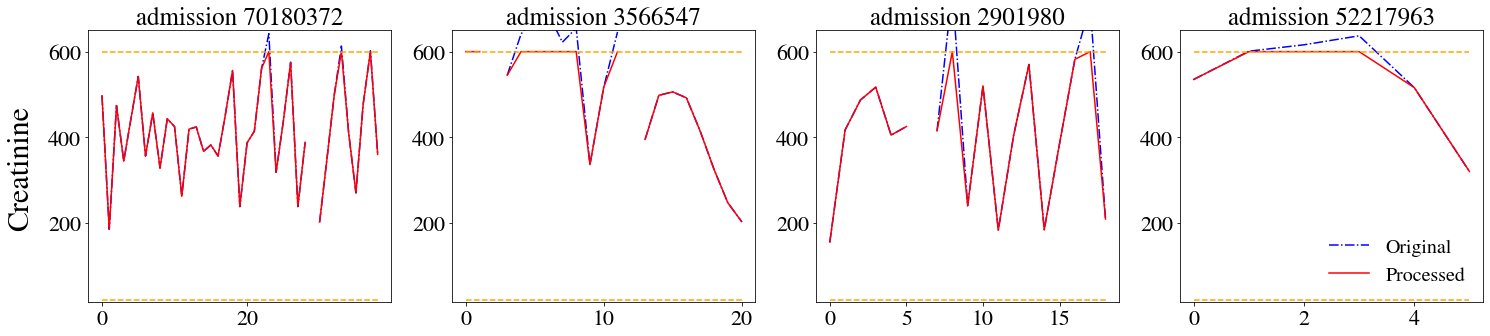

UREA
Values na in UREA 6016
Number of admissions that will change: 706
Number of records out of limits: 3304
Percentage of admins modified for UREA from 11174 is 6.32 %
Percentage of records modified for UREA from 97353 is 3.39 %


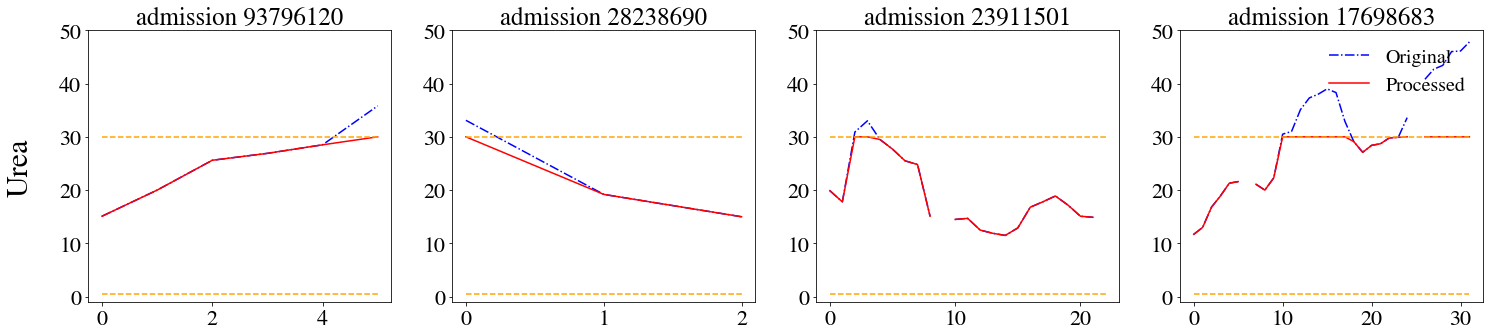

K
Values na in K 6242
Number of admissions that will change: 436
Number of records out of limits: 509
Percentage of admins modified for K from 11174 is 3.90 %
Percentage of records modified for K from 97353 is 0.52 %


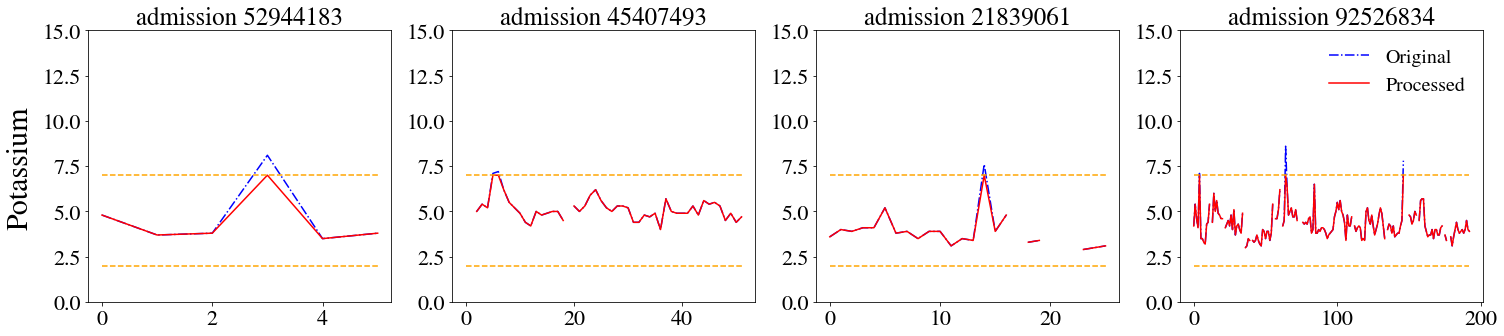

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


EGFR
Values na in EGFR 6670
Number of admissions that will change: 1030
Number of records out of limits: 7433
Percentage of admins modified for EGFR from 11174 is 9.22 %
Percentage of records modified for EGFR from 97353 is 7.64 %


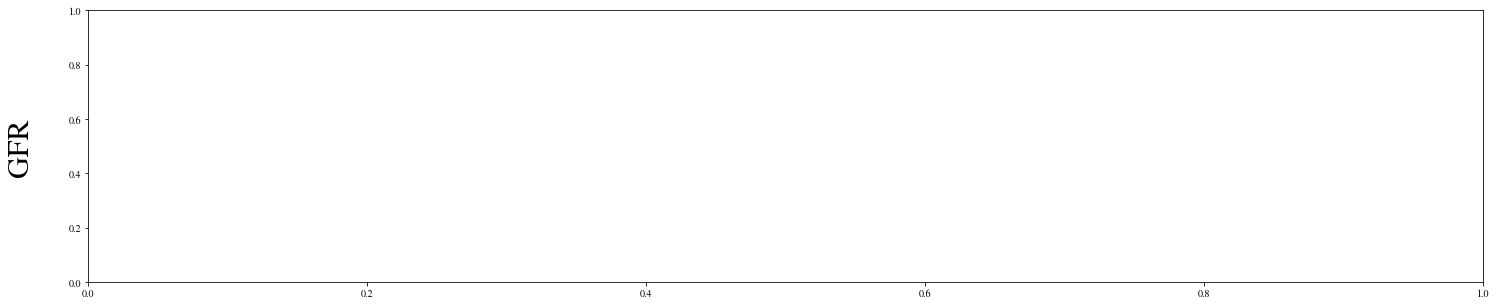

GFR
Values na in GFR 6513
Number of admissions that will change: 858
Number of records out of limits: 6445
Percentage of admins modified for GFR from 11174 is 7.68 %
Percentage of records modified for GFR from 97353 is 6.62 %


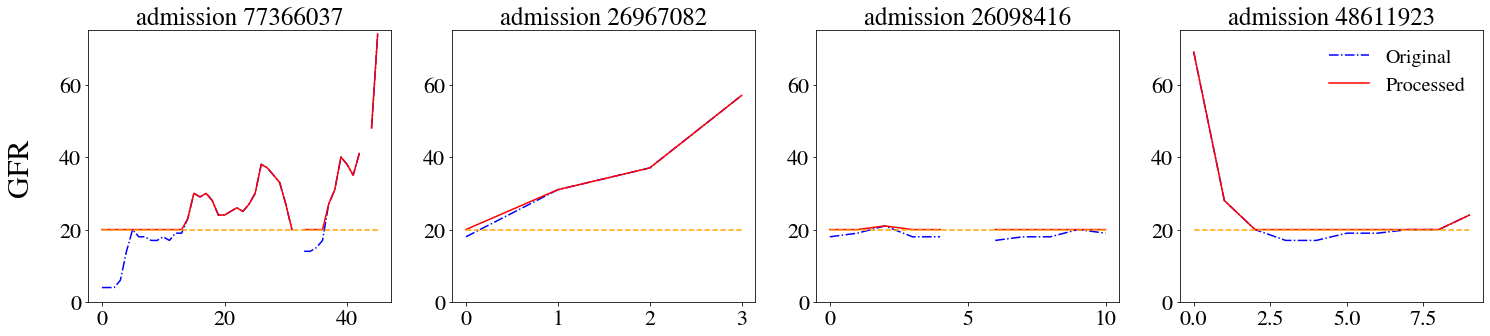

WBC
Values na in WBC 11605
Number of admissions that will change: 637
Number of records out of limits: 3384
Percentage of admins modified for WBC from 11174 is 5.70 %
Percentage of records modified for WBC from 97353 is 3.48 %


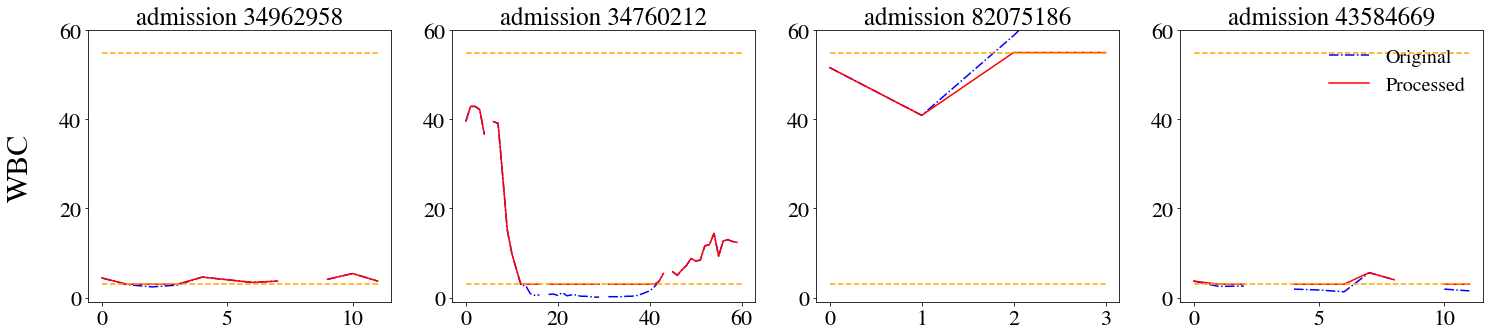

PLT
Values na in PLT 11778
Number of admissions that will change: 1158
Number of records out of limits: 7171
Percentage of admins modified for PLT from 11174 is 10.36 %
Percentage of records modified for PLT from 97353 is 7.37 %


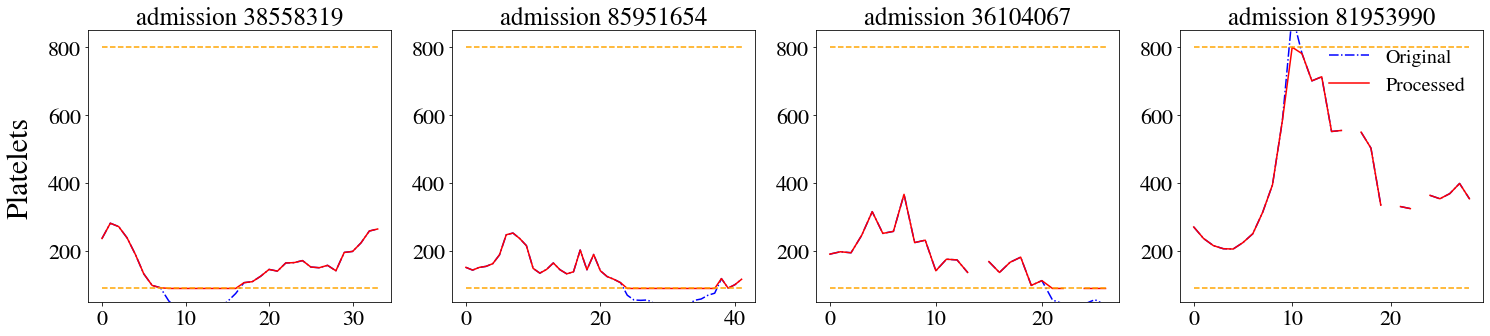

HCT
Values na in HCT 11583
Number of admissions that will change: 274
Number of records out of limits: 641
Percentage of admins modified for HCT from 11174 is 2.45 %
Percentage of records modified for HCT from 97353 is 0.66 %


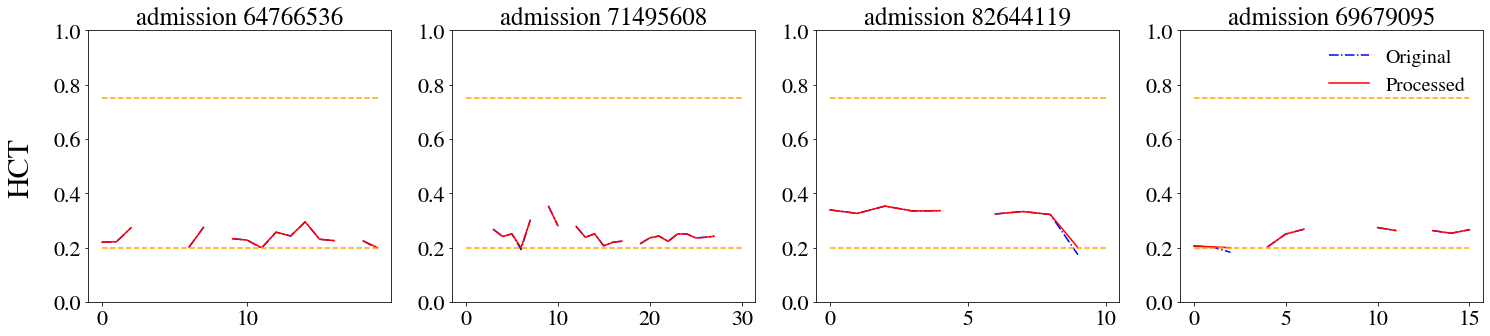

HGB
Values na in HGB 11580
Number of admissions that will change: 489
Number of records out of limits: 1144
Percentage of admins modified for HGB from 11174 is 4.38 %
Percentage of records modified for HGB from 97353 is 1.18 %


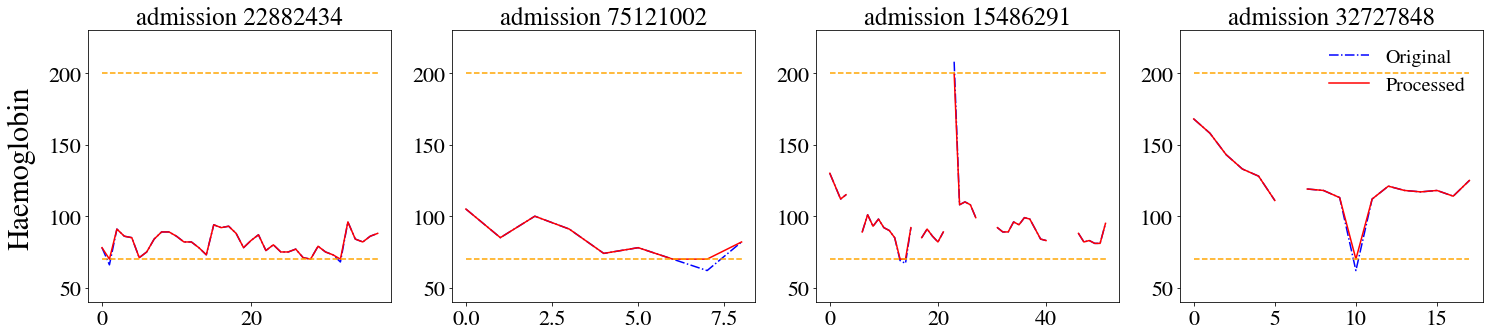

RBC
Values na in RBC 11579
Number of admissions that will change: 183
Number of records out of limits: 497
Percentage of admins modified for RBC from 11174 is 1.64 %
Percentage of records modified for RBC from 97353 is 0.51 %


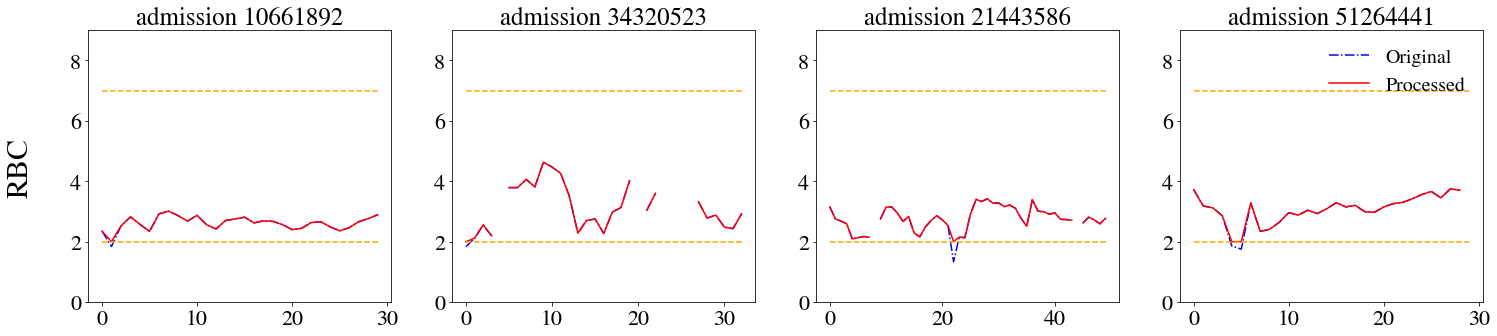

MCH
Values na in MCH 11579
Number of admissions that will change: 113
Number of records out of limits: 487
Percentage of admins modified for MCH from 11174 is 1.01 %
Percentage of records modified for MCH from 97353 is 0.50 %


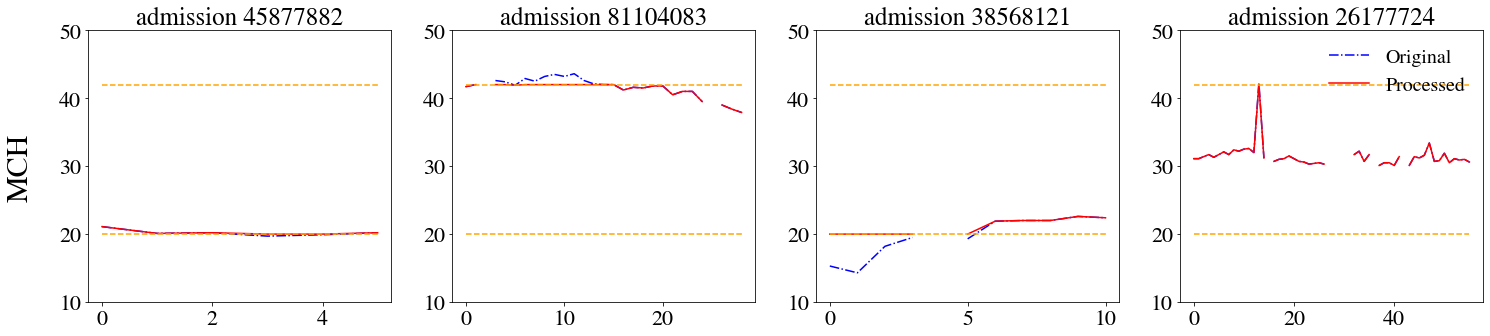

MCV
Values na in MCV 11713
Number of admissions that will change: 221
Number of records out of limits: 1128
Percentage of admins modified for MCV from 11174 is 1.98 %
Percentage of records modified for MCV from 97353 is 1.16 %


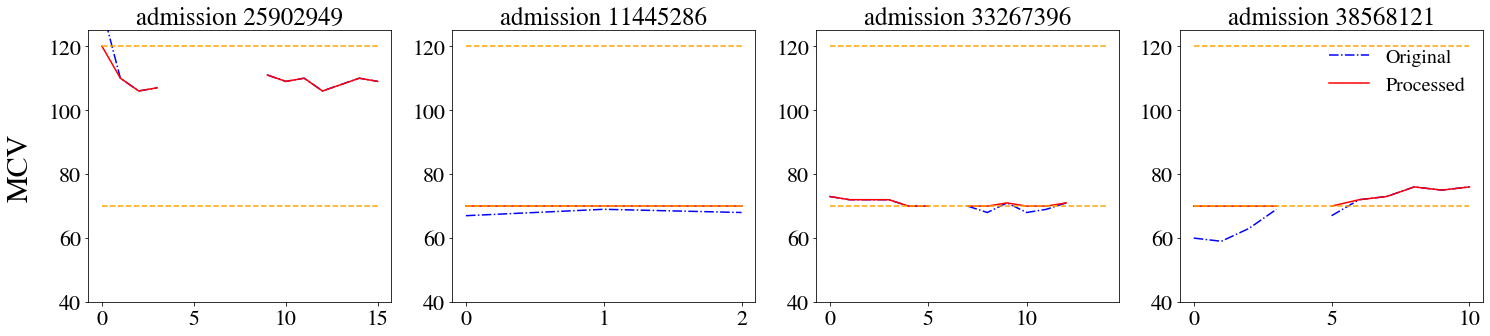

NEUAB
Values na in NEUAB 14974
Number of admissions that will change: 1225
Number of records out of limits: 3238
Percentage of admins modified for NEUAB from 11174 is 10.96 %
Percentage of records modified for NEUAB from 97353 is 3.33 %


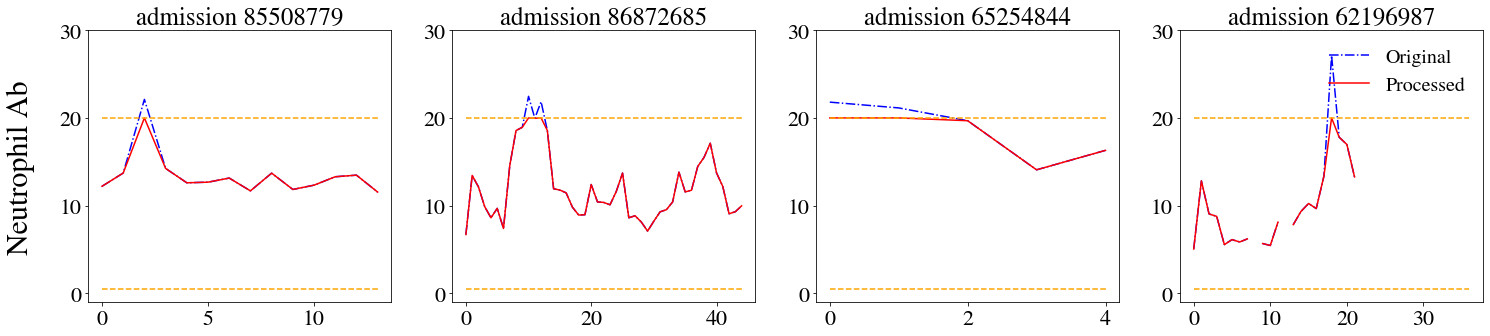

TLYMAB
Values na in TLYMAB 14982
Number of admissions that will change: 844
Number of records out of limits: 2735
Percentage of admins modified for TLYMAB from 11174 is 7.55 %
Percentage of records modified for TLYMAB from 97353 is 2.81 %


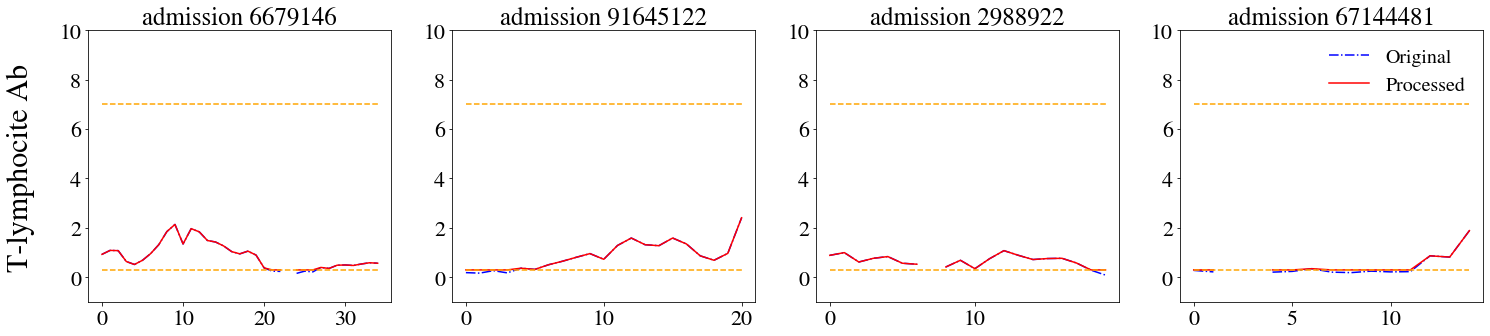

EOSAB
Values na in EOSAB 14982
Number of admissions that will change: 91
Number of records out of limits: 297
Percentage of admins modified for EOSAB from 11174 is 0.81 %
Percentage of records modified for EOSAB from 97353 is 0.31 %


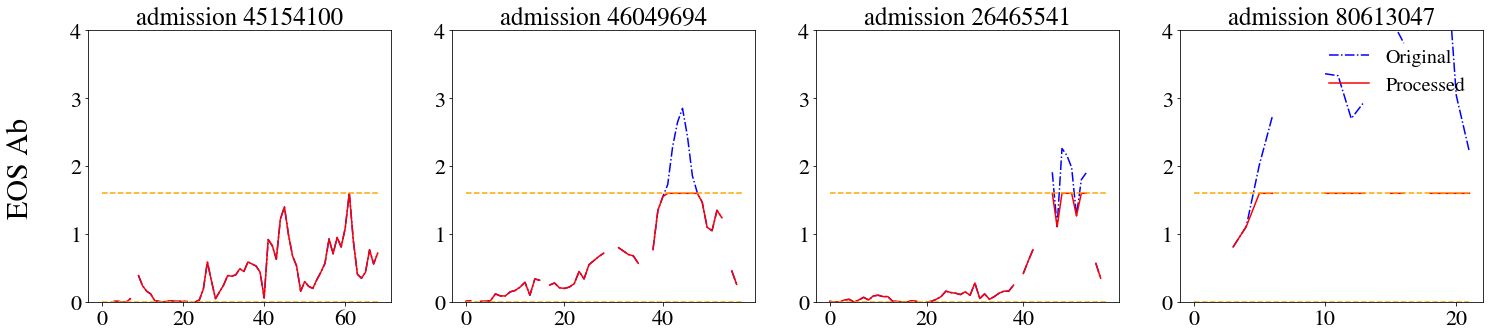

MONAB
Values na in MONAB 15006
Number of admissions that will change: 109
Number of records out of limits: 391
Percentage of admins modified for MONAB from 11174 is 0.98 %
Percentage of records modified for MONAB from 97353 is 0.40 %


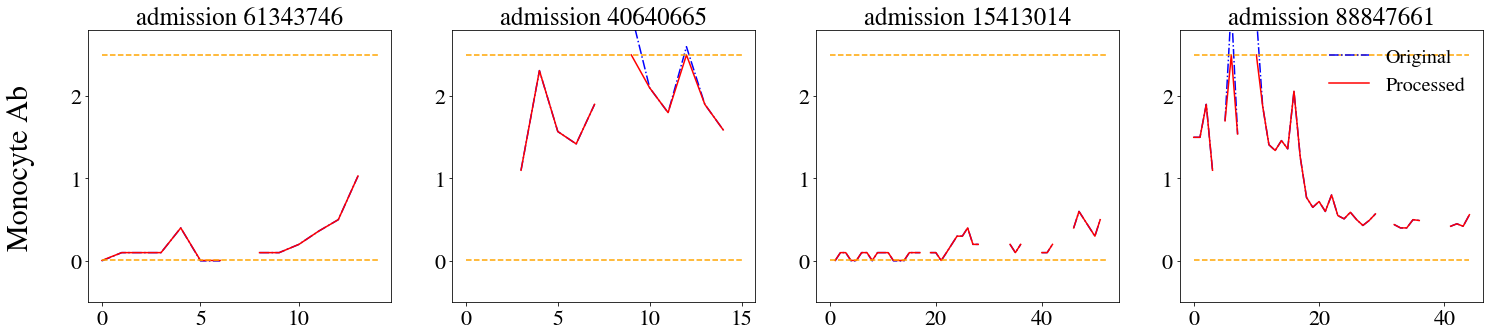

BASAB
Values na in BASAB 15071
Number of admissions that will change: 20
Number of records out of limits: 23
Percentage of admins modified for BASAB from 11174 is 0.18 %
Percentage of records modified for BASAB from 97353 is 0.02 %


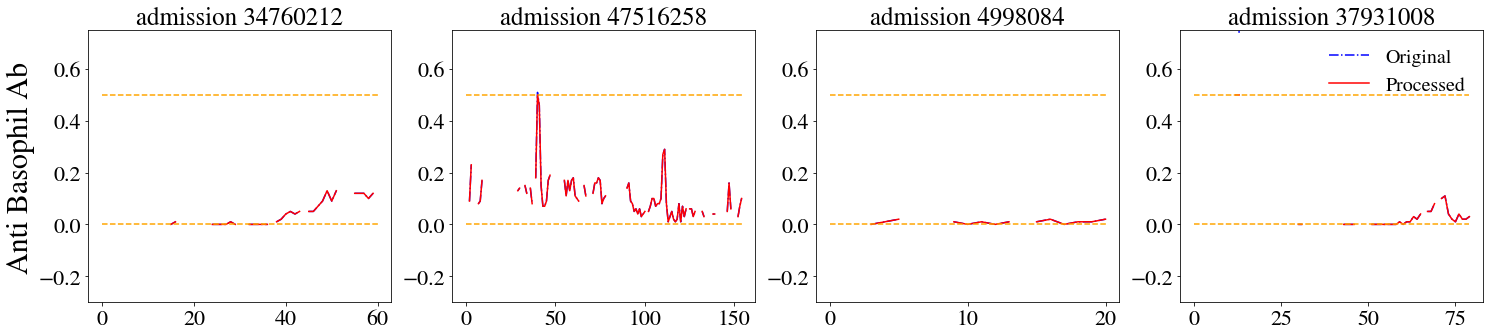

ALB
Values na in ALB 24555
Number of admissions that will change: 170
Number of records out of limits: 457
Percentage of admins modified for ALB from 11174 is 1.52 %
Percentage of records modified for ALB from 97353 is 0.47 %


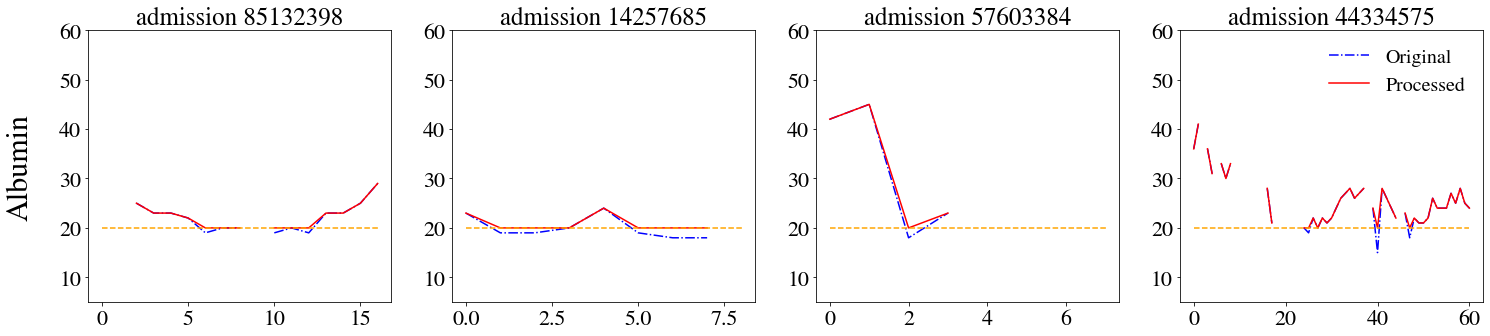

ALP
Values na in ALP 24692
Number of admissions that will change: 566
Number of records out of limits: 2772
Percentage of admins modified for ALP from 11174 is 5.07 %
Percentage of records modified for ALP from 97353 is 2.85 %


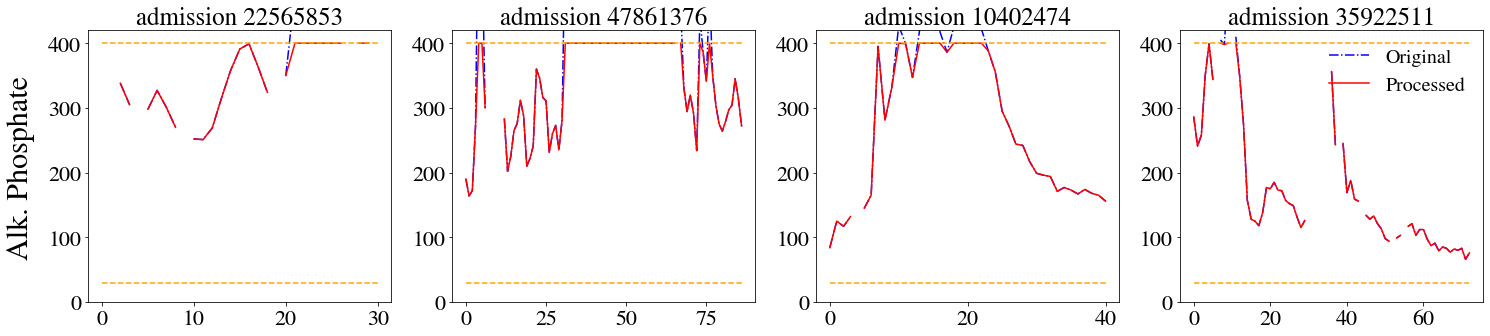

BILI
Values na in BILI 29884
Number of admissions that will change: 427
Number of records out of limits: 2624
Percentage of admins modified for BILI from 11174 is 3.82 %
Percentage of records modified for BILI from 97353 is 2.70 %


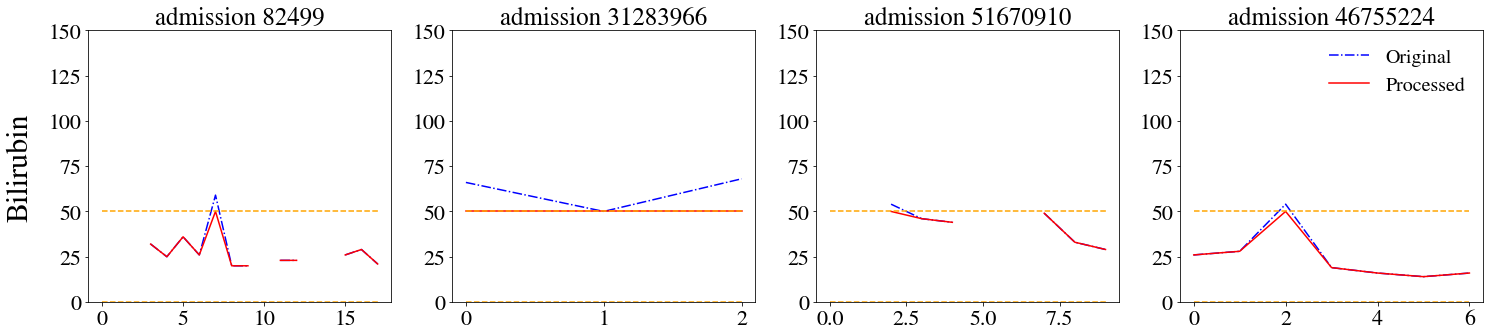

In [26]:
df_haematology_new_v2_n = df_haematology_new_v2[['admission_id','sample_collection_date_time'] +
                                                list(dict_blood_min_max.keys())].copy()
for feat in dict_blood_min_max.keys():
    df_haematology_new_v2_n = handling_errors(feat, df_haematology_new_v2_n, dict_blood_min_max)

In [27]:
display(df_haematology_new_v2[dict_blood_min_max.keys()].describe())
display(df_haematology_new_v2_n[dict_blood_min_max.keys()].describe())

,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,HGB,RBC,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,91340.000000,91337.000000,91111.000000,90683.000000,90840.000000,85748.000000,85575.000000,85770.000000,85773.000000,85774.000000,85774.000000,85640.000000,82379.000000,82371.000000,82371.000000,82347.000000,82282.000000,72798.000000,72661.000000,67469.000000
mean,113.308620,10.558487,4.320541,66.250283,68.386719,11.153548,280.162956,0.346424,111.953925,3.839144,29.372346,90.877032,8.510061,1.327967,0.159672,0.585162,0.041367,34.271944,135.475771,16.297003
std,119.341418,8.109780,0.768376,26.642868,26.049022,12.299101,158.745049,0.068878,22.633151,0.810829,2.874076,8.042241,4.952869,2.327085,0.242111,0.351224,0.109166,6.039650,142.276795,34.978256
min,19.998500,0.900000,1.500000,1.000000,2.000000,0.000000,1.000000,0.076000,23.000000,0.690000,12.100000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.998500,1.998500
25%,57.000000,5.400000,3.900000,46.000000,49.000000,6.900000,173.000000,0.295000,95.000000,3.240000,27.900000,86.000000,5.110000,0.760000,0.030000,0.380000,0.020000,30.000000,74.000000,6.000000
50%,77.000000,8.100000,4.300000,78.000000,82.000000,9.600000,254.000000,0.343000,110.000000,3.810000,29.500000,91.000000,7.530000,1.120000,0.090000,0.530000,0.030000,34.000000,99.000000,9.000000
75%,117.000000,12.800000,4.700000,90.001500,90.001500,13.200000,359.000000,0.395000,128.000000,4.400000,31.000000,95.000000,10.800000,1.600000,0.210000,0.730000,0.050000,38.000000,144.000000,15.000000
max,2263.000000,103.400000,51.900000,90.001500,90.001500,910.400000,1767.000000,0.778000,243.000000,9.560000,48.900000,141.000000,70.340000,301.000000,8.740000,35.710000,28.660000,74.000000,4425.000000,962.000000


,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,HGB,RBC,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
count,91340.000000,91337.000000,91111.000000,90683.000000,90840.000000,85748.000000,85575.000000,85770.000000,85773.000000,85774.000000,85774.000000,85640.000000,82379.000000,82371.000000,82371.000000,82347.000000,82282.000000,72798.000000,72661.000000,67469.000000
mean,110.771042,10.236054,4.312409,66.921170,68.942917,10.844772,281.967046,0.346579,112.041097,3.839747,29.378614,90.908699,8.371571,1.279235,0.156292,0.583914,0.040820,34.289074,125.163595,12.650885
std,103.648401,6.878083,0.699974,25.301906,24.874015,6.224967,148.900040,0.068495,22.415791,0.805597,2.845342,7.802225,4.443626,0.804678,0.205482,0.316842,0.035304,5.992503,81.495281,10.750386
min,20.000000,0.900000,2.000000,20.000000,20.000000,3.000000,90.000000,0.200000,70.000000,2.000000,20.000000,70.000000,0.500000,0.300000,0.000000,0.005000,0.000000,20.000000,30.000000,1.998500
25%,57.000000,5.400000,3.900000,46.000000,49.000000,6.900000,173.000000,0.295000,95.000000,3.240000,27.900000,86.000000,5.110000,0.760000,0.030000,0.380000,0.020000,30.000000,74.000000,6.000000
50%,77.000000,8.100000,4.300000,78.000000,82.000000,9.600000,254.000000,0.343000,110.000000,3.810000,29.500000,91.000000,7.530000,1.120000,0.090000,0.530000,0.030000,34.000000,99.000000,9.000000
75%,117.000000,12.800000,4.700000,90.001500,90.001500,13.200000,359.000000,0.395000,128.000000,4.400000,31.000000,95.000000,10.800000,1.600000,0.210000,0.730000,0.050000,38.000000,144.000000,15.000000
max,600.000000,30.000000,7.000000,90.001500,90.001500,55.000000,800.000000,0.750000,200.000000,7.000000,42.000000,120.000000,20.000000,7.000000,1.600000,2.500000,0.500000,70.000000,400.000000,50.000000


In [28]:
df_haematology_new_v2_n.head(4)

,admission_id,sample_collection_date_time,CREA,UREA,K,EGFR,GFR,WBC,PLT,HCT,...,MCH,MCV,NEUAB,TLYMAB,EOSAB,MONAB,BASAB,ALB,ALP,BILI
0,9297156,2020-09-14 13:58:00,155.0,22.9,4.7,36.0,40.0,16.9,476.0,0.332,...,32.2,94.0,15.53,0.70,0.01,0.60,0.01,43.0,79.0,19.0
1,9297156,2020-09-15 09:27:00,107.0,19.9,4.2,56.0,61.0,14.4,372.0,0.296,...,31.5,94.0,12.18,1.59,0.04,0.54,0.01,37.0,69.0,15.0
2,9297156,2020-09-17 09:05:00,83.0,14.7,4.3,76.0,82.0,7.4,320.0,0.305,...,31.2,94.0,5.52,1.31,0.22,0.32,0.03,33.0,64.0,11.0
3,91590293,2020-04-06 11:53:00,213.0,11.5,4.7,20.0,21.0,14.7,504.0,0.370,...,27.4,87.0,12.72,1.19,0.07,0.70,0.03,39.0,164.0,7.0


In [29]:
print("number of features in heamatology",len(df_haematology_new_v2_n.columns))
display(df_haematology_new_v2_n.columns)
#len(dict_blood_min_max)

number of features in heamatology 22


Index(['admission_id', 'sample_collection_date_time', 'CREA', 'UREA', 'K',
       'EGFR', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB',
       'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI'],
      dtype='object')

# 6. Looking at null and type values

In [30]:
df = pd.concat([df_haematology_new_v2_n.isna().sum(), df_haematology_new_v2_n.dtypes], axis=1)
df = df.rename(columns ={0:'nulls',1:'type'})
display(df.sort_values(by=['nulls']))

,nulls,type
admission_id,0,int64
sample_collection_date_time,0,datetime64[ns]
CREA,6013,float64
UREA,6016,float64
K,6242,float64
GFR,6513,float64
EGFR,6670,float64
MCH,11579,float64
RBC,11579,float64
HGB,11580,float64


# 7. Placing number of blood test in admissions dataframe

In [31]:
t = time.time()
admin_obs = []
for adm in df_admissions[admission_field]:    
    admin_obs.append(len(df_haematology_new_v2_n[df_haematology_new_v2_n[admission_field] == adm]))
df_admissions.loc[:,no_haematology_field] = admin_obs

print("number of admissions", len(df_admissions))
print('times elapsed, during adding no_heamatology_field: ',time.time() - t)
df_admissions.head(4)

number of admissions 14714
times elapsed, during adding no_heamatology_field:  6.479255199432373


,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs,no_haematology_eobs
3,99645131,"||E10.5,L97.X,L08.9,R02.X,A41.9,R65.1,N17.9,E1...",18026138,55,2021-11-25 16:34:00,18956.690278,2021-12-31 14:48:00,18992.616667,35 days 22:14:00,1,0,0,2,169,19
4,21362780,"||U07.1,J12.8,B97.2,J15.9,B97.2,Z86.7||U07.1,J...",27754209,45,2021-11-12 17:21:00,18943.722917,2021-11-20 14:00:00,18951.583333,7 days 20:39:00,1,0,0,0,42,3
5,13991116,"||A41.9,U07.1,J12.8,B97.2,K75.0,K92.0,J90.X,I8...",54047888,70,2020-04-20 21:48:00,18372.908333,2020-05-20 05:30:00,18402.229167,29 days 07:42:00,1,1,0,1,210,29
6,58580641,"||U07.2,J12.8,E11.9,Z86.1",56373663,66,2020-05-21 08:05:00,18403.336806,2020-05-21 15:07:00,18403.629861,0 days 07:02:00,1,0,0,1,7,0


# 8. Pickling Data

In [32]:
pickling_data = [df_patients, df_admissions]
pickle.dump(pickling_data, open('DataFrame_pickles/df_patients_admissions_v3.pickle', 'wb'))
pickling_data = [df_haematology_new_v2_n]
pickle.dump(pickling_data, open('DataFrame_pickles/df_haematology_v1.pickle', 'wb'))

In [33]:
len(df_haematology_new_v2_n['admission_id'].unique())

11174

In [34]:
print("number of admissions", len(df_admissions))

number of admissions 14714


# Look at reference ranges

In [35]:
list_codes = ['CREA','UREA','K','EGFR','GFR','WBC','AKIDUM','PLT','HCT','HGB','RBC','MCH','MCV','NRBCAD','NEUAB',
              'TLYMAB' ,'EOSAB', 'MONAB','BASAB','CRP','ALB','ALP','BILI' ,'ALT','TP','PHOS','ACA','CG','INR','CA',
              'MG','PT']
for code in list_codes:
    ranges = df_haemt[df_haemt['local_test_code'] == code]['refererence_range'].unique().tolist()
    units_ = df_haemt[df_haemt['local_test_code'] == code]['units'].unique().tolist()
    print(code)
    print(ranges)
    print(units_)
    print("")
    #break

CREA
['60{120', nan, '48{81', '43{75', '54{99', '34{100', '40{83', '47{98', '34{76', '44{79', '38{74', '38{76', '23{37']
['umol/L', nan]

UREA
['2.5{7.8', '2.5{6.5', nan]
['mmol/L', nan]

K
['3.5{5.3', nan, '3.5{5.0', '3.3{5.3']
['mmol/L', nan]

EGFR
[nan]
['mL/min/1.73m', 'mL/min', nan]

GFR
[nan]
['mL/min/1.73m', nan]

WBC
['4.0{11.0', nan, '4.5{13.0', '5.0{15.5']
['x10^9/L', nan]

AKIDUM
[nan, '0{0.9']
[nan]

PLT
['140{400', nan]
['x10^9/L', nan, 'X10^9/L']

HCT
['0.400{0.540', '0.370{0.470', nan, '0.370{0.540']
['L/L']

HGB
['115{165', '130{180', nan, '115{145', '115{180']
['g/L']

RBC
['3.90{5.60', '4.50{6.50', nan, '3.90{5.50', '3.90{6.50']
['x10^12/L', 'X10^12/L']

MCH
['27.0{32.0', nan, '25.0{32.0']
['pg']

MCV
['80.0{99.0', nan, '77.0{95.0']
['fL', 'fl', nan]

NRBCAD
['0.00{0.20', nan]
['x10^9/L']

NEUAB
['1.50{7.50', '1.80{8.00', nan, '1.50{8.00']
['x10^9/L', 'X10^9/L']

TLYMAB
['1.00{4.00', nan, '1.50{6.00', '1.50{6.50']
['x10^9/L', 'X10^9/L']

EOSAB
['0.04{0.40', nan]
['x10